Link to the Dataset: https://www.kaggle.com/datasets/nikhil1e9/loan-default

In [5]:
# Importing Libraries

import numpy as np
import pandas as pd
from numpy import mean
from numpy import std
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('ggplot')
from plotly import tools
import plotly.offline as py
import plotly.figure_factory as ff
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
from  matplotlib.ticker import PercentFormatter
import shap

import warnings
warnings.filterwarnings('ignore')

#for displaying 500 results in pandas dataframe
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import itertools
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.metrics import precision_score, recall_score, roc_auc_score,confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc, RocCurveDisplay, precision_recall_curve, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, make_scorer
import warnings

In [6]:
# read in the data
train = pd.read_csv('Loan_default.csv')
train.head()

,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default
0,I38PQUQS96,56,85994,50587,520,80,4,15.23,36,0.44,Bachelor's,Full-time,Divorced,Yes,Yes,Other,Yes,0
1,HPSK72WA7R,69,50432,124440,458,15,1,4.81,60,0.68,Master's,Full-time,Married,No,No,Other,Yes,0
2,C1OZ6DPJ8Y,46,84208,129188,451,26,3,21.17,24,0.31,Master's,Unemployed,Divorced,Yes,Yes,Auto,No,1
3,V2KKSFM3UN,32,31713,44799,743,0,3,7.07,24,0.23,High School,Full-time,Married,No,No,Business,No,0
4,EY08JDHTZP,60,20437,9139,633,8,4,6.51,48,0.73,Bachelor's,Unemployed,Divorced,No,Yes,Auto,No,0


In [26]:
train.drop(['LoanID'], axis=1, inplace=True)

In [27]:
# Split into features and target (X and y)
X = train.drop("Default", axis=1)
y = train["Default"]

In [28]:
# stratify=y helps maintain the class distribution for imbalanced datasets.
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [29]:
# Get columns with object or category dtype
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
print(cat_cols)

['Education', 'EmploymentType', 'MaritalStatus', 'HasMortgage', 'HasDependents', 'LoanPurpose', 'HasCoSigner']


In [30]:
# Categorical columns for encoding
# cat_cols = ['EMPLOYMENT_TYPE', 'PERFORM_CNS_SCORE_DESCRIPTION']
cat_cols = [col for col in cat_cols if col in X.columns]

# Frequency Encoding(Apply frequency encoding using only the training data, then map to test)
for col in cat_cols:
    freq_map = X_train[col].value_counts().to_dict() # Get frequency of each category in train
    X_train[col] = X_train[col].map(freq_map) # Replace train values with frequencies
    X_test[col] = X_test[col].map(freq_map).fillna(-1)  # Map test values: unseen categories get 0


In [31]:
# X_train["Education"]

In [32]:
weight = np.sum(y_train == 0) / np.sum(y_train == 1)

model = XGBClassifier(
    scale_pos_weight=weight,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring="roc_auc")

print("Cross-validated ROC-AUC scores:", cv_scores)
print("Mean AUC:", np.mean(cv_scores))

Cross-validated ROC-AUC scores: [0.72960757 0.7350007  0.72819014 0.73576178 0.7339656 ]
Mean AUC: 0.7325051580358443


In [33]:
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("Test ROC AUC:", roc_auc_score(y_test, y_proba))

              precision    recall  f1-score   support

           0       0.94      0.72      0.82     45139
           1       0.23      0.63      0.34      5931

    accuracy                           0.71     51070
   macro avg       0.58      0.68      0.58     51070
weighted avg       0.86      0.71      0.76     51070

Test ROC AUC: 0.7438082440261176


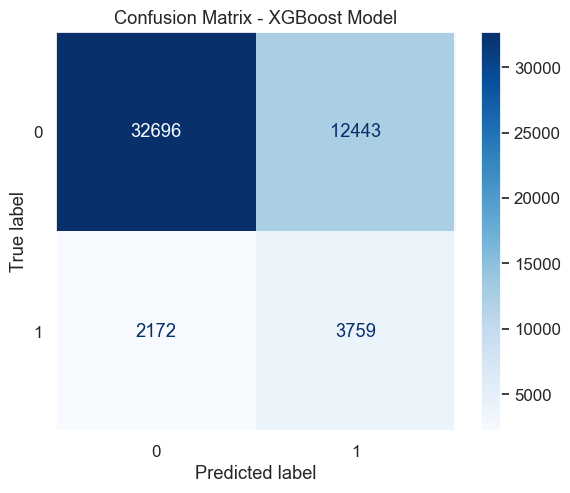

In [34]:
# Predict class labels
y_pred = model.predict(X_test)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
fig, ax = plt.subplots(figsize=(6, 5))
disp.plot(ax=ax, cmap='Blues', values_format='d')
plt.title("Confusion Matrix - XGBoost Model")
plt.grid(False)
plt.tight_layout()
plt.show()


In [35]:
column_explanations = {
    'LoanID': 'Unique identifier for each loan application.',
    'Age': 'Age of the loan applicant in years.',
    'Income': 'Monthly or annual income of the applicant (typically in local currency).',
    'LoanAmount': 'Total amount of money requested for the loan.',
    'CreditScore': 'Numerical score representing the applicant’s creditworthiness.',
    'MonthsEmployed': 'Number of months the applicant has been employed at their current job.',
    'NumCreditLines': 'Total number of open credit lines (e.g., credit cards, other loans).',
    'InterestRate': 'Interest rate applied to the loan, expressed as a percentage.',
    'LoanTerm': 'Duration of the loan repayment period, typically in months.',
    'DTIRatio': 'Debt-to-Income Ratio; measures monthly debt payments relative to monthly income.',
    'Education': 'Highest level of education attained by the applicant (e.g., High School, Bachelor, Master).',
    'EmploymentType': 'Type of employment (e.g., Full-Time, Part-Time, Self-Employed, Unemployed).',
    'MaritalStatus': 'Marital status of the applicant (e.g., Single, Married, Divorced).',
    'HasMortgage': 'Indicates if the applicant currently has a mortgage (1 for yes, 0 for no).',
    'HasDependents': 'Indicates if the applicant has dependents (1 for yes, 0 for no).',
    'LoanPurpose': 'The stated purpose for taking the loan (e.g., Debt Consolidation, Home Improvement, Education).',
    'HasCoSigner': 'Indicates if the loan has a co-signer (1 for yes, 0 for no).',
    'Default': 'Target variable indicating whether the loan was defaulted (1 for defaulted, 0 for not defaulted).'
}

In [36]:
# shap_values[1]

In [23]:
new_pred_proba = model.predict_proba(X_test)[:, 1]

# Generate SHAP explainer
explainer = shap.Explainer(model)
shap_values = explainer(X_test)

X_test['predictions'] = y_pred
X_test['pred_proba'] = new_pred_proba

# Extract only rows where predicted = 1
df_predicted_defaulters = X_test[X_test['predictions'] == 1].copy()
test_defaulters = X_test.loc[df_predicted_defaulters.index]

# Store results
explanations = []

for i, row_index in enumerate(test_defaulters.index):
    row = test_defaulters.loc[row_index]
    shap_row = shap_values[i]
    
    # Top 5 features by absolute SHAP value
    top_features = sorted(
        zip(shap_row.feature_names, shap_row.values),
        key=lambda x: abs(x[1]),
        reverse=True
    )[:5]
    
    # Build prompt
    prompt = "Explain why this customer may default based on:\n"
    for feature, impact in top_features:
        val = row[feature]
        desc = column_explanations.get(feature, "No description.")
        prompt += f"- {feature} ({desc}): value = {val}, SHAP impact = {impact:.2f}\n"
    
    prompt += "\nGenerate a human-readable explanation for this loan default risk."

    # Save
    explanations.append({
        "index": row_index,
        "top_shap_features": [f[0] for f in top_features],
        "chatgpt_prompt": prompt
    })

# Convert to DataFrame
df_explanations = pd.DataFrame(explanations).set_index("index")

# # Drop rule_explanation in df_predicted_defaulters to avoid conflict
# df_predicted_defaulters = df_predicted_defaulters.drop(columns=["rule_explanation"], errors="ignore")

# Join with original test data
df_summary = df_predicted_defaulters.join(df_explanations, how="left")

In [ ]:
import nest_asyncio
import asyncio
from openai import AsyncOpenAI
import shap
import matplotlib.pyplot as plt
import os

nest_asyncio.apply()  # Needed for Jupyter environments

# Initialize OpenAI client
client = AsyncOpenAI(api_key="")  # Replace with your actual API key

# Async function to fetch GPT explanation
async def fetch_explanation(prompt):
    try:
        response = await client.chat.completions.create(
            model="gpt-4o",
            messages=[{"role": "user", "content": prompt}],
            temperature=0.4,
            max_tokens=300
        )
        return response.choices[0].message.content
    except Exception as e:
        return f"ERROR: {str(e)}"

# Main async loop to process all defaulters
async def process_defaulters(df, shap_values, output_dir="shap_plots"):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    print("🧪 Number of rows to process:", len(df))
    
    explanations = []
    for i, (idx, row) in enumerate(df.iterrows()):
        prompt = row["chatgpt_prompt"]

        # Fetch GPT explanation
        explanation = await fetch_explanation(prompt)

        # Save SHAP plot
        plt.figure()
        shap.plots.waterfall(shap_values[i], show=False)
        plot_path = os.path.join(output_dir, f"shap_{idx}.png")
        plt.savefig(plot_path, bbox_inches="tight")
        plt.close()

        # Update row
        df.at[idx, "gpt_explanation"] = explanation
        df.at[idx, "shap_plot_path"] = plot_path

    return df

# Add new columns to df_summary if not already present
df_summary["gpt_explanation"] = ""
df_summary["shap_plot_path"] = ""

# Limit to first 100 rows
df_subset = df_summary.head(100).copy()
shap_subset = shap_values[:100]  # Ensure SHAP values match the subset size

# Run processing on the 100-row subset
df_summary_final = await process_defaulters(df_subset, shap_subset)

# Save to CSV
df_summary_final.to_csv("loan_default_explanations.csv", index=False)

# Display a few rows for confirmation
df_summary_final[["chatgpt_prompt", "gpt_explanation", "shap_plot_path"]].head()

🧪 Number of rows to process: 100


,chatgpt_prompt,gpt_explanation,shap_plot_path
127976,Explain why this customer may default based on...,"Based on the provided information, we can anal...",shap_plots/shap_127976.png
26516,Explain why this customer may default based on...,"Based on the provided information, the custome...",shap_plots/shap_26516.png
82635,Explain why this customer may default based on...,Based on the provided SHAP impact values and f...,shap_plots/shap_82635.png
7384,Explain why this customer may default based on...,"Based on the provided information, we can eval...",shap_plots/shap_7384.png
196329,Explain why this customer may default based on...,Based on the provided SHAP impact values and f...,shap_plots/shap_196329.png


In [ ]:
def rule_based_explanation(row):
    explanations = []

    #Age
    if row["Age"] < 40: explanations.append("Young age may indicate lack of financial experience.")
    #Income
    if row["Income"] < 50000: explanations.append("Low income may indicate financial instability.")
    #LoanAmount
    if row["LoanAmount"] > 150000: explanations.append("High loan amount increases risk of default.")
    #CreditScore
    if row["CreditScore"] < 600: explanations.append("Low credit score indicates high risk of default.")
    #MonthsEmployed
    if row["MonthsEmployed"] < 60: explanations.append("Short employment duration may indicate job instability.")
    #NumCreditLines
    #InterestRate
    if row["InterestRate"] > 15: explanations.append("High interest rate increases financial burden, raising risk.")
    #LoanTerm
    #DTIRatio
    if row["DTIRatio"] > 0.5: explanations.append("High debt-to-income ratio indicates financial strain.")
    #Education
    if row["Education"] == "High School": explanations.append("Low education level may impact job prospects.")
    if row["Education"] == "Bachelor's": explanations.append("Low education level may impact job prospects.")
    #EmploymentType
    if row["EmploymentType"] == "Unemployed": explanations.append("Unemployed status is a significant risk factor.")
    if row["EmploymentType"] == "Part-time": explanations.append("Part-time employment may lead to unstable income.")
    #MaritalStatus
    if row["MaritalStatus"] == "Divorced": explanations.append("Divorce can lead to financial instability, increasing risk.")
    if row["MaritalStatus"] == "Single": explanations.append("Single status may indicate less financial support, increasing risk.")
    #HasMortgage
    if row["HasMortgage"] == "No": explanations.append("No mortgage may indicate lower financial obligations, but also less stability.")
    if row["HasMortgage"] == "Yes": explanations.append("Existing mortgage increases financial obligations, raising risk.")
    #HasDependents
    if row["HasDependents"] == "No": explanations.append("Dependents increase financial obligations, raising risk.")
    if row["HasDependents"] == "Yes": explanations.append("No dependents may indicate lower financial obligations, reducing risk.")
    #LoanPurpose
    if row["LoanPurpose"] == "Business": explanations.append("Business loans can be riskier due to market volatility.")
    #HasCoSigner
    if row["HasCoSigner"] == "No": explanations.append("No co-signer increases risk; co-signers can provide additional security.")
    if row["HasCoSigner"] == "Yes": explanations.append("Co-signer provides additional security, reducing risk.")
    
    # Default fallback
    if not explanations: explanations.append("No obvious red flags; investigate model rationale.")

    return " | ".join(set(explanations[:10]))  # limit to 10 concise reasons per row

# Apply rules only to predicted defaulters
X_test["rule_explanation"] = X_test.apply(lambda row: rule_based_explanation(row) if row["predictions"] == 1 else "", axis=1)

In [37]:
# Get columns with object or category dtype
cat_cols = train.select_dtypes(include=['object', 'category']).columns.tolist()
print(cat_cols)

['Education', 'EmploymentType', 'MaritalStatus', 'HasMortgage', 'HasDependents', 'LoanPurpose', 'HasCoSigner']


In [45]:
def plot_disc(col):
    output_dir = "cat_plots"
    if not os.path.exists(output_dir):
            os.makedirs(output_dir)
    percentages_df = train.groupby('Default')[col].value_counts(normalize=True).mul(100).rename('percentage').reset_index()
    plt.figure(figsize=(8, 6))
    sns.barplot(data=percentages_df, x=col, y='percentage', hue='Default')

    plot_path = os.path.join(output_dir, f"hist_{col}.png")
    plt.savefig(plot_path, bbox_inches="tight")
    plt.close()
    # plt.show()

In [46]:
plot_disc("Education")

for col in cat_cols:
        plot_disc(col)



In [59]:
train["HasCoSigner"].unique()

array(['Yes', 'No'], dtype=object)

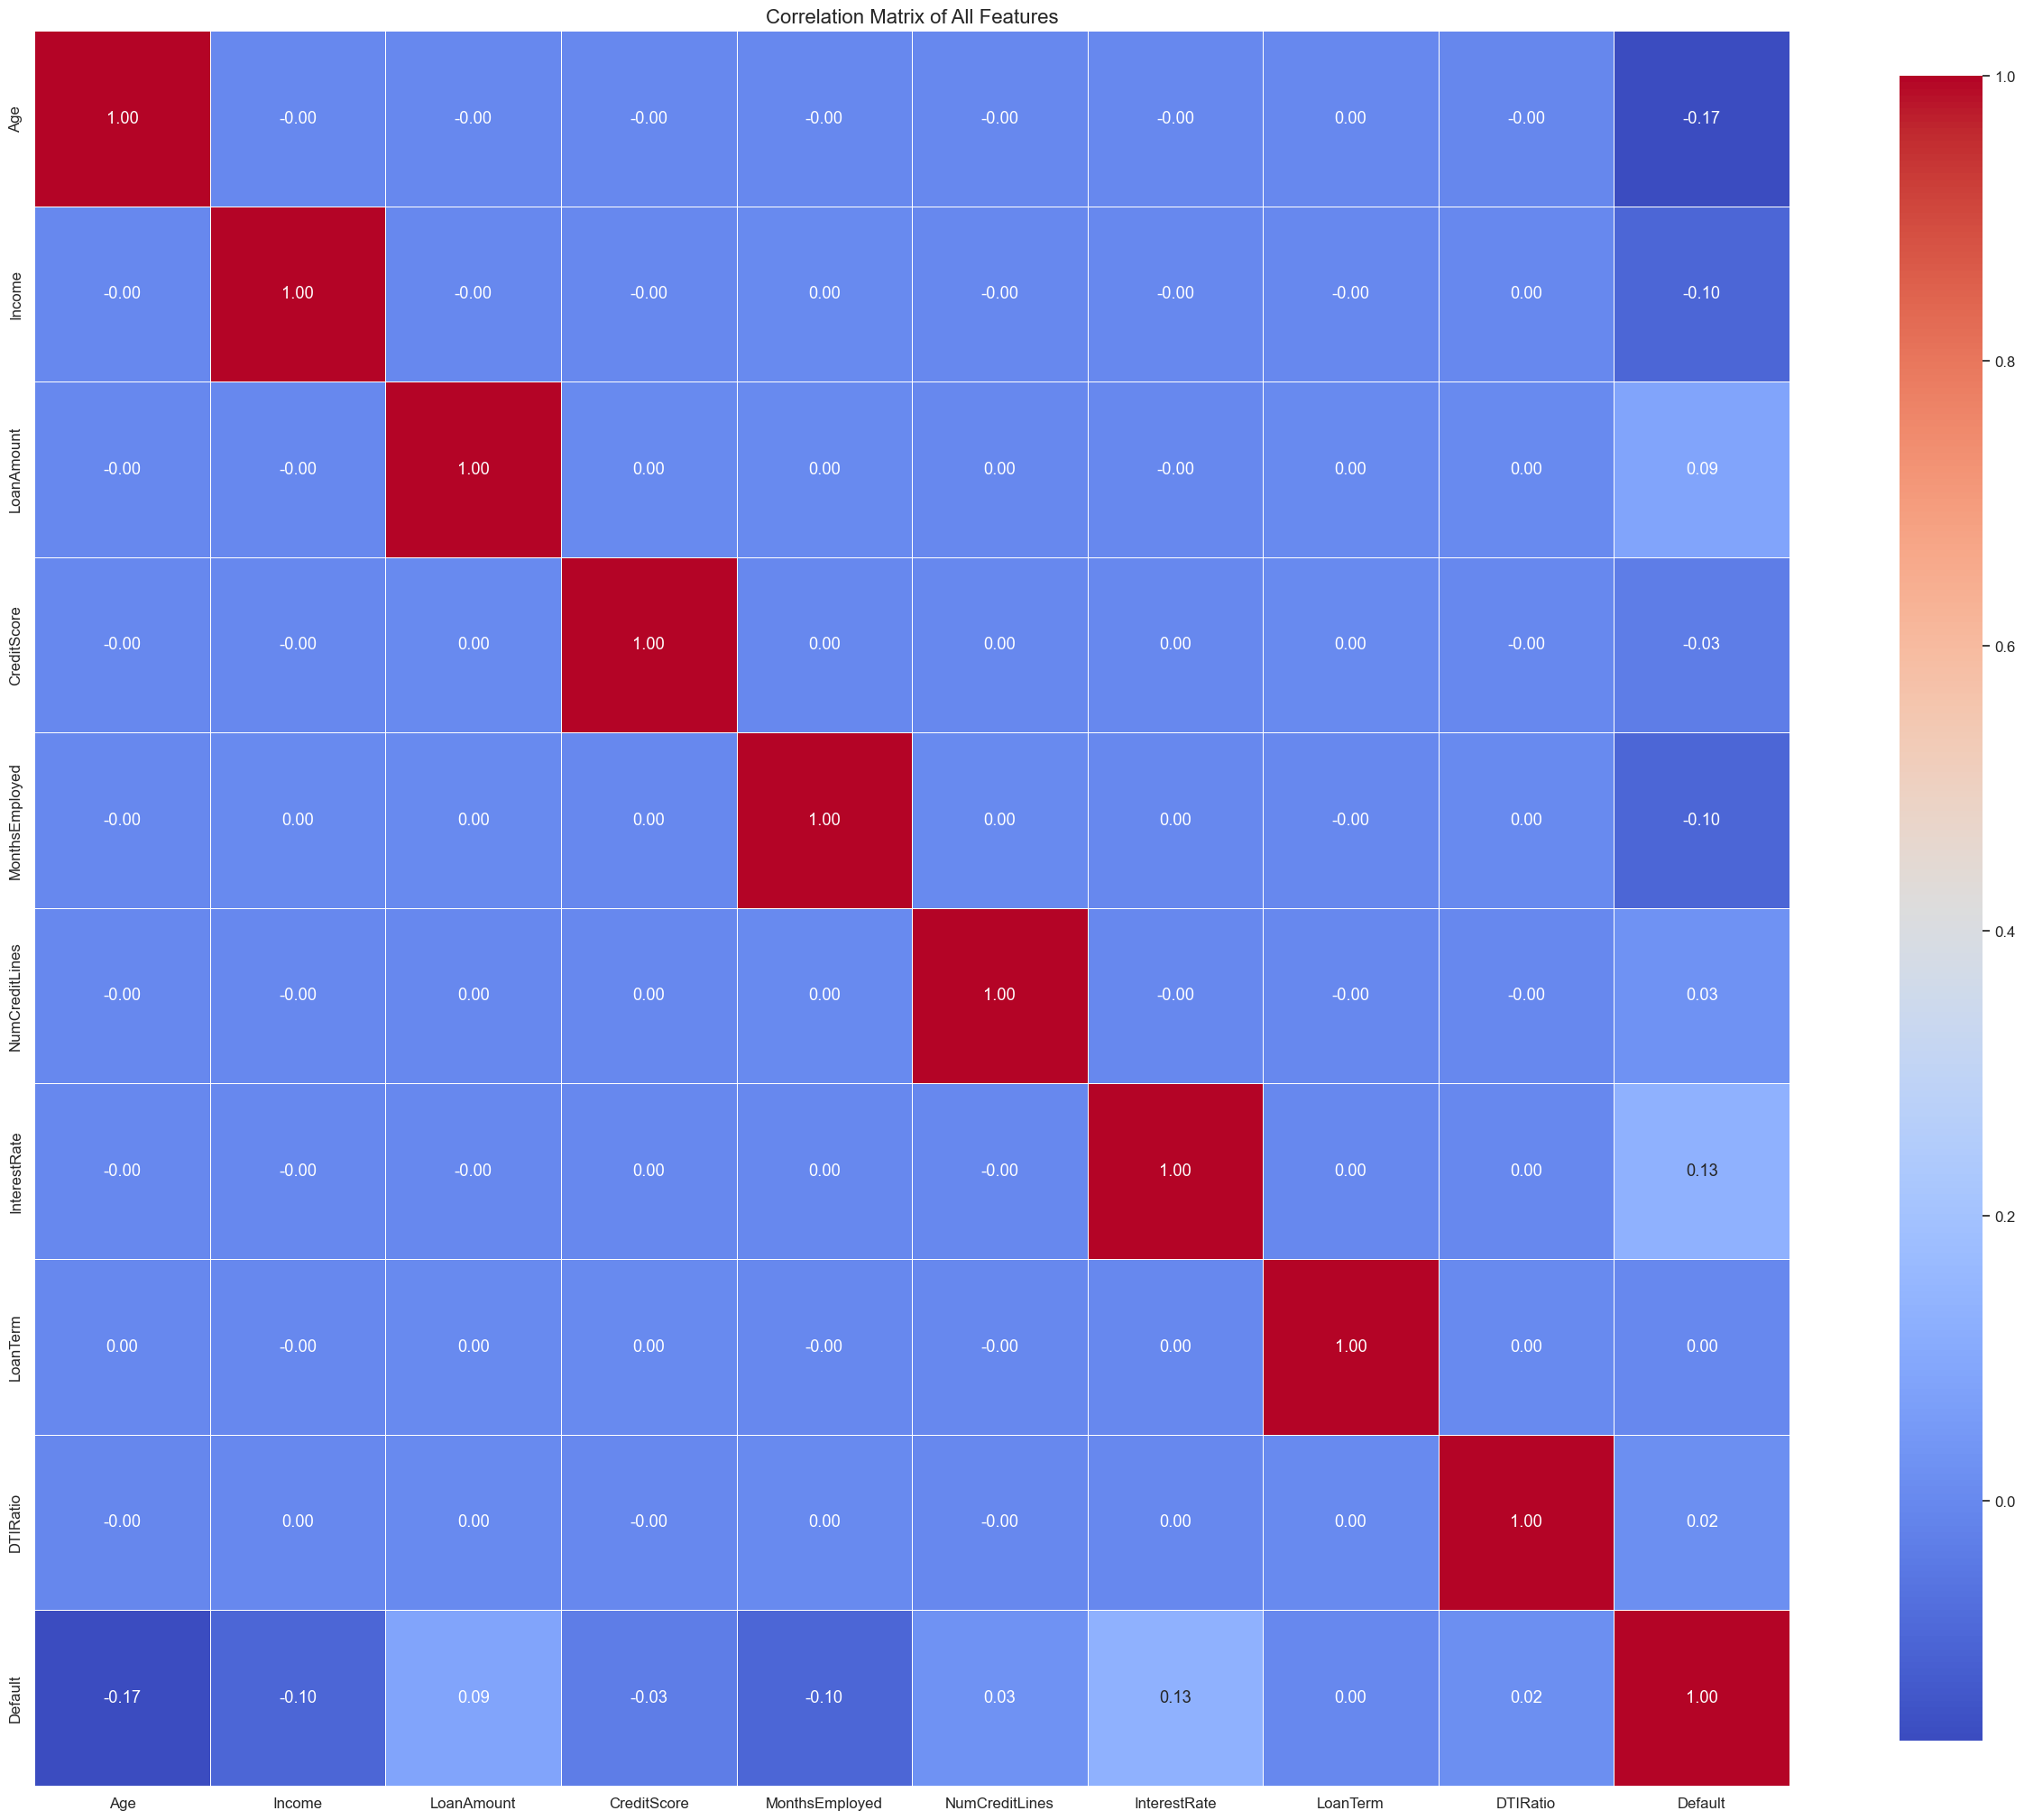

In [47]:
# Compute the correlation matrix
corr_matrix = train.corr(numeric_only=True)

# Set up the matplotlib figure
plt.figure(figsize=(25, 25))
sns.set(font_scale=1.1)

# Draw the heatmap
sns.heatmap(corr_matrix, 
            annot=True,          # Show correlation coefficients
            fmt=".2f",           # Format for values
            cmap='coolwarm',     # Color map
            square=True, 
            linewidths=0.5, 
            cbar_kws={"shrink": .75})

plt.title('Correlation Matrix of All Features', fontsize=16)
plt.tight_layout()
plt.show()

In [52]:

def plot_disc_num(col):
    output_dir = "num_plots"
    if not os.path.exists(output_dir):
            os.makedirs(output_dir)

    default_1 = train[train['Default'] == 1][col]
    default_0 = train[train['Default'] == 0][col]
    plt.figure(figsize=(10, 6))
    sns.kdeplot(default_0, label='Default 0', fill=True, alpha=0.5)
    sns.kdeplot(default_1, label='Default 1', fill=True, alpha=0.5)
    plt.title('Normalized Distribution of Two Classes')
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plot_path = os.path.join(output_dir, f"num_{col}.png")
    plt.savefig(plot_path, bbox_inches="tight")
    plt.close()

In [53]:
num_cols = train.select_dtypes(exclude=['object', 'category']).columns.tolist()
print(num_cols)

['Age', 'Income', 'LoanAmount', 'CreditScore', 'MonthsEmployed', 'NumCreditLines', 'InterestRate', 'LoanTerm', 'DTIRatio', 'Default']


In [54]:
# plot_disc_num("LoanAmount")

for col in num_cols:
        plot_disc_num(col)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
